In [11]:
import numpy as np
import matplotlib.pyplot as plt
import helper as hp
import os

In [12]:
def fGenerator(frequency, samplingRate):
    
    def f(n):        
        return np.cos(2*np.pi*frequency/samplingRate*n)
    
    return f

In [13]:
BASE = 2000
DEVIATION = 2000
SAMPLING_RATE = 22050

SAMPLES_PER_SYMBOL = 100
BETA = 1/2


def phi(i):
    return fGenerator(BASE + i*DEVIATION, SAMPLING_RATE)

def raised_cosine(beta, period):
    
    def f(n):
        return (4 * beta)/(np.pi * np.sqrt(period)) * \
               (np.cos((1+beta)*np.pi*n/period) + (1-beta)*np.pi/(4*beta)*np.sinc((1-beta)*n/period))/ \
               (1-np.square((4*beta*n/period)))
        
    
    limit_raised_cosine_critical_points = beta/(np.pi*np.sqrt(2*period)) * \
                                          ((np.pi + 2)*np.sin(np.pi/(4*beta)) + (np.pi-2)*np.cos(np.pi/(4*beta)))
    
    def g(n):
        return np.piecewise(float(n), [(np.abs(n) != period/(4*beta)), (np.abs(n) == period/(4*beta))], \
                            [lambda x : f(x), lambda x : limit_raised_cosine_critical_points])
    
    return g

def waveformer(n):
    return raised_cosine(BETA, SAMPLES_PER_SYMBOL)(n-SAMPLES_PER_SYMBOL/2)*(phi(0)(n) + phi(1)(n) + phi(2)(n) + phi(3)(n))

In [14]:
def generic_encoder(bool_message, samples_per_symbol, f):
    
    result = []
    
    for s in bool_message:
        for i in range(samples_per_symbol):
            result.append((1 if s else -1)*f(i))
    #résultat à normaliser !
    return result

In [15]:
def generic_decoder(float_message, samples_per_symbol, length_of_bool_message, synchro_shift, f):
    
    synchronised_message = float_message[synchro_shift:synchro_shift + samples_per_symbol*length_of_bool_message]
    result = []

    assert len(synchronised_message)%samples_per_symbol == 0
    length = length_of_bool_message
    decoding_vector = generic_encoder([True],samples_per_symbol, f)
    
    for i in range(length):
        currentSymbol = synchronised_message[i*samples_per_symbol:(i+1)*samples_per_symbol]
        y = np.dot(decoding_vector, currentSymbol)
        result.append(y>0)
    
    return result

In [16]:
def synchro_seq_generator(seed, length):
    
    np.random.seed(seed)   
    bool_sequence = np.random.randint(2, size = length)
    
    return bool_sequence


def synchronizer(float_message, preambule_matcher, postbule_matcher, samples_per_symbol, f):
    
    preambule_float = generic_encoder(preambule_matcher, SAMPLES_PER_SYMBOL, f)  
    postbule_float  = generic_encoder(postbule_matcher, SAMPLES_PER_SYMBOL, f)
    
    return (np.argmax(np.correlate(float_message, preambule_float, "valid")), \
            np.argmax(np.correlate(float_message, postbule_float,  "valid")))

In [17]:
def create_send_file(preambule, boolean_message, postbule, path, f):

    print("Nombre de bits du message envoyé", len(boolean_message))
    
    sent_test_message = generic_encoder(np.concatenate((preambule,boolean_message,postbule)), \
                                        SAMPLES_PER_SYMBOL, f)

    normalized_sent_test_message = sent_test_message/np.max(sent_test_message)
    
    print("Nombre d'échantillons envoyés", str(len(normalized_sent_test_message)))

    plt.plot(np.abs(np.fft.fft(normalized_sent_test_message)))

    with open(path, "w") as fd:
        for fl in sent_test_message:
            fd.write(str(fl))
            fd.write("\n")

In [18]:
def decode_file(preambule, postbule, path, f):
    result_message = []

    with open(path,"r") as fr:  
        for cnt, line in enumerate(fr):
            result_message.append(float(line))
    
    delay_index, end_index = synchronizer(result_message, preambule, postbule, SAMPLES_PER_SYMBOL, f)
    synchro_shift = delay_index + len(preambule)*SAMPLES_PER_SYMBOL
    length_bool_message = int(np.around((end_index - synchro_shift)/SAMPLES_PER_SYMBOL))
    print("Nombre de bits du message reçu", length_bool_message)
    
    result_bool_message = generic_decoder(result_message, SAMPLES_PER_SYMBOL, \
                                          length_bool_message, synchro_shift, f)

    plt.plot(np.abs(np.fft.fft(result_message[delay_index:delay_index+(len(preambule)+length_bool_message)*SAMPLES_PER_SYMBOL])))
    
    print("Nombre d'échantillons reçus", str(len(result_message)))
    print("Délais",  str(delay_index))
    print("FFT de ", str(delay_index), "à", str(delay_index+(len(preambule)+length_bool_message+len(postbule))*SAMPLES_PER_SYMBOL))
    print("Préambule", preambule)
    print("Postbule",  postbule)
    
    return result_bool_message

Nombre de bits du message envoyé 1288
Nombre d'échantillons envoyés 133600
Message envoyé


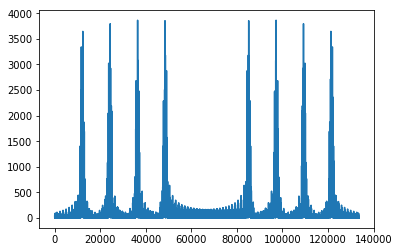

In [19]:
preambule = synchro_seq_generator(None, 24)
postbule  = synchro_seq_generator(None, 24)

create_send_file(preambule, hp.read_file("input.txt"), postbule, "sent_message.txt", waveformer)

print("Message envoyé")


In [20]:
os.system("python client.py --input_file sent_message.txt --output_file received_message.txt --srv_hostname=iscsrv72.epfl.ch --srv_port=80")
result = decode_file(preambule, postbule, "received_message.txt", waveformer)
hp.write_file(result, "output.txt")

Nombre de bits du message reçu -24


ValueError: Dimension n should be a positive integer not larger than the shape of the array along the chosen axis

In [ ]:
hp.check_successful_transmission("input.txt", "output.txt")